# Определение перспективного тарифа для телеком-компании

Содержание
1. [Описание проекта](#start)
2. [Обзор данных](#data_view)
3. [Предобработка данных](#preprocessing)
4. [Анализ данных](#analysis)
5. [Проверка гипотез](#hypothesis)
6. [Общий вывод](#conclusion)

## Описание проекта <a id='start'></a>

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов  
Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля, сообщение: 3 рубля, 1 Гб интернет-трафика: 200 рублей
**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль, сообщение: 1 рубль, 1 Гб интернет-трафика: 150 рублей

*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

## Обзор данных <a id='data_view'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()
display(calls.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 202607 entries, 0 to 202606

Data columns (total 4 columns):

 #   Column     Non-Null Count   Dtype  

---  ------     --------------   -----  

 0   id         202607 non-null  object 

 1   call_date  202607 non-null  object 

 2   duration   202607 non-null  float64

 3   user_id    202607 non-null  int64  

dtypes: float64(1), int64(1), object(2)

memory usage: 6.2+ MB


0

Первичный анализ таблицы calls (информация о звонках) показал:
1. В таблице представлена информация: уникальный номер звонка (id), дата звонка (call_date), длительность звонка в минутах (duration), идентификатор пользователя, сделавшего звонок (user_id).
2. Явные пропуски отсутствуют.
3. Дата звонка сохранена, как строка.
4. Явные дубликаты отсутствуют.

In [4]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
internet.info()
display(internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 149396 entries, 0 to 149395

Data columns (total 5 columns):

 #   Column        Non-Null Count   Dtype  

---  ------        --------------   -----  

 0   Unnamed: 0    149396 non-null  int64  

 1   id            149396 non-null  object 

 2   mb_used       149396 non-null  float64

 3   session_date  149396 non-null  object 

 4   user_id       149396 non-null  int64  

dtypes: float64(1), int64(2), object(2)

memory usage: 5.7+ MB


0

Первичный анализ таблицы internet (информация об интернет-сессиях показал:
1. В таблице представлена информация: уникальный номер сессии (id), объём потраченного за сессию интернет-трафика (в мегабайтах) (mb_used), дата интернет-сессии (session_date), идентификатор пользователя (user_id).
2. Явные пропуски отсутствуют.
3. Дата интернет-сессии сохранена, как строка.
4. Сохранен столбец с индексом (Unnamed).
5. Явные дубликаты отсутствуют.

In [6]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()
display(messages.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 123036 entries, 0 to 123035

Data columns (total 3 columns):

 #   Column        Non-Null Count   Dtype 

---  ------        --------------   ----- 

 0   id            123036 non-null  object

 1   message_date  123036 non-null  object

 2   user_id       123036 non-null  int64 

dtypes: int64(1), object(2)

memory usage: 2.8+ MB


0

Первичный анализ таблицы messages (информация о сообщениях) показал:
1. В таблице представлена информация: уникальный номер сообщения (id), дата сообщения (message_date), идентификатор пользователя, отправившего сообщение (user_id).
2. Явные пропуски отсутствуют.
3. Дата сообщения сохранена, как строка.

In [8]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2 entries, 0 to 1

Data columns (total 8 columns):

 #   Column                 Non-Null Count  Dtype 

---  ------                 --------------  ----- 

 0   messages_included      2 non-null      int64 

 1   mb_per_month_included  2 non-null      int64 

 2   minutes_included       2 non-null      int64 

 3   rub_monthly_fee        2 non-null      int64 

 4   rub_per_gb             2 non-null      int64 

 5   rub_per_message        2 non-null      int64 

 6   rub_per_minute         2 non-null      int64 

 7   tariff_name            2 non-null      object

dtypes: int64(7), object(1)

memory usage: 256.0+ bytes


Первичный анализ таблицы tariffs (информация о тарифах) показал:
1. В таблице представлена информация: название тарифа (tariff_name), ежемесячная абонентская плата в рублях (rub_monthly_fee), количество минут разговора в месяц, включённых в абонентскую плату (minutes_included), количество сообщений в месяц, включённых в абонентскую плату (messages_included), объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) (mb_per_month_included), стоимость минуты разговора сверх тарифного пакета (rub_per_minute), стоимость отправки сообщения сверх тарифного пакета (rub_per_message), стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (rub_per_gb).
2. Явные пропуски отсутствуют.
3. Все количественные показатели сохранены, как вещественные числа, хотя они натуральные.
4. Явные дубликаты отсутствуют.

In [10]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()
display(users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 500 entries, 0 to 499

Data columns (total 8 columns):

 #   Column      Non-Null Count  Dtype 

---  ------      --------------  ----- 

 0   user_id     500 non-null    int64 

 1   age         500 non-null    int64 

 2   churn_date  38 non-null     object

 3   city        500 non-null    object

 4   first_name  500 non-null    object

 5   last_name   500 non-null    object

 6   reg_date    500 non-null    object

 7   tariff      500 non-null    object

dtypes: int64(2), object(6)

memory usage: 31.4+ KB


0

Первичный анализ таблицы users (информация о пользователях) показал:
1. В таблице представлена информация: уникальный идентификатор пользователя (user_id), имя пользователя (first_name), фамилия пользователя (last_name), возраст пользователя (годы) (age), дата подключения тарифа (reg_date), дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) (churn_date), город проживания пользователя (city), название тарифного плана (tariff).
2. Даты сохранены, как строки.
3. user_id  и age сохранены как вещественные числа, хотя они натуральные.
4. Явные дубликаты отсутствуют.

Таким образом, во всех таблицах обнаружен неверный формат даты. Название тарифного плана во всех таблицах обозначится как tariff, кроме таблицы с информацией о тарифах (tariff_name). Также необходимо округлить время звонков и количество мегабайт трафика в большую сторону в соответствии с условиями тарифов.

## Предобработка данных <a id='preprocessing'></a>

Для дальнейшего анализа и расчетов заменим тип данных для дат:

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')
calls.info()
internet.info()
messages.info()
users.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 202607 entries, 0 to 202606

Data columns (total 4 columns):

 #   Column     Non-Null Count   Dtype         

---  ------     --------------   -----         

 0   id         202607 non-null  object        

 1   call_date  202607 non-null  datetime64[ns]

 2   duration   202607 non-null  float64       

 3   user_id    202607 non-null  int64         

dtypes: datetime64[ns](1), float64(1), int64(1), object(1)

memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 149396 entries, 0 to 149395

Data columns (total 5 columns):

 #   Column        Non-Null Count   Dtype         

---  ------        --------------   -----         

 0   Unnamed: 0    149396 non-null  int64         

 1   id            149396 non-null  object        

 2   mb_used       149396 non-null  float64       

 3   session_date  149396 non-null  datetime64[ns]

 4   user_id       149396 non-null  int64         

dtypes: datetime64[ns](1), float6

Удалим столбец с индексом (Unnamed) в таблице internet

In [13]:
internet = internet.drop(columns='Unnamed: 0')
internet.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 149396 entries, 0 to 149395

Data columns (total 4 columns):

 #   Column        Non-Null Count   Dtype         

---  ------        --------------   -----         

 0   id            149396 non-null  object        

 1   mb_used       149396 non-null  float64       

 2   session_date  149396 non-null  datetime64[ns]

 3   user_id       149396 non-null  int64         

dtypes: datetime64[ns](1), float64(1), int64(1), object(1)

memory usage: 4.6+ MB


Переименуем столбец tariff_name в tariffs по аналогии с остальными таблицами.

In [14]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})
tariffs.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2 entries, 0 to 1

Data columns (total 8 columns):

 #   Column                 Non-Null Count  Dtype 

---  ------                 --------------  ----- 

 0   messages_included      2 non-null      int64 

 1   mb_per_month_included  2 non-null      int64 

 2   minutes_included       2 non-null      int64 

 3   rub_monthly_fee        2 non-null      int64 

 4   rub_per_gb             2 non-null      int64 

 5   rub_per_message        2 non-null      int64 

 6   rub_per_minute         2 non-null      int64 

 7   tariff                 2 non-null      object

dtypes: int64(7), object(1)

memory usage: 256.0+ bytes


Рассчитаем количество сделанных звонков и израсходованных минут разговора по месяцам. 

In [15]:
#сформируем столбец month в таблице calls
calls['month'] = calls['call_date'].astype('datetime64[M]')
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-01


In [16]:
#сформируем переменную user_calls, в которую сохраним количество звонков (calls_total_in_month) 
#и минут разговора по месяца (month_calls_duration)
user_calls = (calls
                  .groupby(['user_id', 'month'])
                  .agg({'duration':'sum', 'id':'count'})
                  .reset_index()
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})
)
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,2018-05-01,150.06,22
1,1000,2018-06-01,158.90,43
2,1000,2018-07-01,318.80,47
3,1000,2018-08-01,389.87,52
4,1000,2018-09-01,440.14,58


Рассчитаем количество отправленных сообщений по месяцам.

In [17]:
#сформируем столбец month в таблице messages
messages['month'] = messages['message_date'].astype('datetime64[M]')
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [18]:
#сформируем переменную user_messages, в которую сохраним количество сообщений (sms_total_in_month) 
user_messages = (messages
                        .groupby(['user_id', 'month'])
                        .agg({'id':'count'})
                        .reset_index()
                        .rename(columns={'id':'sms_total_in_month'})
)

user_messages.head()

,user_id,month,sms_total_in_month
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


Рассчитаем объем израсходованного интернет-трафика по месяцам.

In [19]:
#сформируем столбец month в таблице internet
internet['month'] = internet['session_date'].astype('datetime64[M]')
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


In [20]:
#сформируем переменную user_internet, в которую объем израсходованного интернет-трафика (mb_total_in_month) 
user_internet = (internet
                        .groupby(['user_id', 'month'])
                        .agg({'mb_used':'sum'})
                        .reset_index()
                        .rename(columns={'mb_used':'mb_total_in_month'})
)
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91


Округлим время звонков и количество мегабайт трафика в большую сторону в соответствии с условиями тарифов.

In [21]:
#округлим в большую сторону звонки
user_calls['calls_total_in_month'] = np.ceil(user_calls['calls_total_in_month']).astype('int')
 
# округлим в большую сторону крличество мб
user_internet['mb_total_in_month'] = np.ceil(user_internet['mb_total_in_month']).astype('int')

#выведем таблицы calls и internet и информации о них после преобразований
display(calls.head())
calls.info()
display(internet.head())
internet.info()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-01


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 202607 entries, 0 to 202606

Data columns (total 5 columns):

 #   Column     Non-Null Count   Dtype         

---  ------     --------------   -----         

 0   id         202607 non-null  object        

 1   call_date  202607 non-null  datetime64[ns]

 2   duration   202607 non-null  float64       

 3   user_id    202607 non-null  int64         

 4   month      202607 non-null  datetime64[ns]

dtypes: datetime64[ns](2), float64(1), int64(1), object(1)

memory usage: 7.7+ MB


,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 149396 entries, 0 to 149395

Data columns (total 5 columns):

 #   Column        Non-Null Count   Dtype         

---  ------        --------------   -----         

 0   id            149396 non-null  object        

 1   mb_used       149396 non-null  float64       

 2   session_date  149396 non-null  datetime64[ns]

 3   user_id       149396 non-null  int64         

 4   month         149396 non-null  datetime64[ns]

dtypes: datetime64[ns](2), float64(1), int64(1), object(1)

memory usage: 5.7+ MB


Рассчитаем помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

In [22]:
#сформируем общий датафрейм по количеству и продолжительности звонков, количеству сообщений и интернет трафику
#объединим информацию по звонкам и сообщения
telecom_data = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
display(telecom_data.head())
display(telecom_data.isna().sum())
telecom_data.duplicated().sum()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month
0,1000,2018-05-01,150.06,22.0,22.0
1,1000,2018-06-01,158.90,43.0,60.0
2,1000,2018-07-01,318.80,47.0,75.0
3,1000,2018-08-01,389.87,52.0,81.0
4,1000,2018-09-01,440.14,58.0,57.0


user_id                   0
month                     0
month_calls_duration     39
calls_total_in_month     39
sms_total_in_month      496
dtype: int64

0

In [23]:
#объединим информацию по звонкам и сообщения и интернет трафику
telecom_data = telecom_data.merge(user_internet, on=['user_id','month'], how='outer')
display(telecom_data.head())
display(telecom_data.isna().sum())
telecom_data.duplicated().sum()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month
0,1000,2018-05-01,150.06,22.0,22.0,2254.0
1,1000,2018-06-01,158.90,43.0,60.0,23234.0
2,1000,2018-07-01,318.80,47.0,75.0,14004.0
3,1000,2018-08-01,389.87,52.0,81.0,14056.0
4,1000,2018-09-01,440.14,58.0,57.0,14569.0


user_id                   0
month                     0
month_calls_duration     40
calls_total_in_month     40
sms_total_in_month      497
mb_total_in_month        11
dtype: int64

0

In [24]:
#добавим информацию о пользователях
telecom_data = telecom_data.merge(users, on='user_id', how='left')
display(telecom_data.head())
display(telecom_data.isna().sum())
telecom_data.duplicated().sum()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,150.06,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,158.90,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,318.80,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,389.87,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,440.14,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


user_id                    0
month                      0
month_calls_duration      40
calls_total_in_month      40
sms_total_in_month       497
mb_total_in_month         11
age                        0
churn_date              3027
city                       0
first_name                 0
last_name                  0
reg_date                   0
tariff                     0
dtype: int64

0

In [25]:
#добавим информацию о тарифах
telecom_data = telecom_data.merge(tariffs, on='tariff', how='left')
display(telecom_data.head())
display(telecom_data.isna().sum())
telecom_data.duplicated().sum()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,150.06,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,158.90,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,318.80,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,389.87,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,440.14,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


user_id                     0
month                       0
month_calls_duration       40
calls_total_in_month       40
sms_total_in_month        497
mb_total_in_month          11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

0

Заполним пропуски в данных month_calls_duration, calls_total_in_month, sms_total_in_month, mb_total_in_month (пользователи, которые не тратят интернет, или не пишут смс, или не звонят).

In [26]:
columns = ['month_calls_duration', 'calls_total_in_month', 'sms_total_in_month', 'mb_total_in_month']
for i in columns:
    telecom_data[i] = telecom_data[i].fillna(0)
display(telecom_data.isna().sum())

user_id                     0
month                       0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [27]:
#посчитаем платежи сверх тарифного плана
def above_tariff(row):
    sms = (row['sms_total_in_month'] - row['messages_included']) * row['rub_per_message']
    mins = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.ceil((row['mb_total_in_month'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb'] 
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total
telecom_data['above_tariff'] = telecom_data.apply(lambda x: above_tariff(x), axis=1)

#посчитаем общую сумму платежей
telecom_data['total_paid'] = telecom_data['rub_monthly_fee'] + telecom_data['above_tariff']
display(telecom_data.sort_values(by='total_paid').tail())
pd.set_option('display.max_columns', None)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_tariff,total_paid
1793,1286,2018-12-01,693.79,95.0,68.0,35109.0,19,NaN,Москва,Рашид,...,smart,50,15360,500,550,200,3,3,4635.37,5185.37
1622,1261,2018-12-01,1015.89,141.0,22.0,32651.0,46,NaN,Казань,Мадина,...,smart,50,15360,500,550,200,3,3,4947.67,5497.67
3105,1486,2018-11-01,723.39,108.0,96.0,36267.0,35,NaN,Нижний Новгород,Матвей,...,smart,50,15360,500,550,200,3,3,5008.17,5558.17
260,1042,2018-12-01,680.16,121.0,75.0,37166.0,42,NaN,Хабаровск,Константин,...,smart,50,15360,500,550,200,3,3,5015.48,5565.48
3106,1486,2018-12-01,954.70,133.0,83.0,38553.0,35,NaN,Нижний Новгород,Матвей,...,smart,50,15360,500,550,200,3,3,6063.10,6613.10


## Анализ данных <a id='analysis'></a>

Проведем анализ платежей по тарифам.

In [28]:
display(telecom_data[['above_tariff', 'total_paid']].describe())
display(telecom_data['tariff'].value_counts())
display(telecom_data.groupby('tariff')['total_paid'].sum())

,above_tariff,total_paid
count,3214.000000,3214.000000
mean,527.258563,1506.318923
std,749.130090,792.756078
min,0.000000,550.000000
25%,0.000000,740.717500
50%,120.630000,1564.190000
75%,890.000000,1950.000000
max,6063.100000,6613.100000


smart    2229
ultra     985
Name: tariff, dtype: int64

tariff
smart    2802209.02
ultra    2039100.00
Name: total_paid, dtype: float64

Таким образом, общая сумма платежей в месяц колеблется от 550 руб. (ежемесячный платеж без платежей сверх тарифа Смарт) до 6613 руб., среднее значение составляет - 1506 руб., а медианальное - 1564 руб. Количество клиентов, использующие тариф Смарт, больше, чем клиентов, использующий тариф Ультра, приблизительно в два раза. Тариф Смарт приносит больше выручки, чем Ультра. Построим диаграмму размаха по общей сумме платежей в разрезе тарифов.

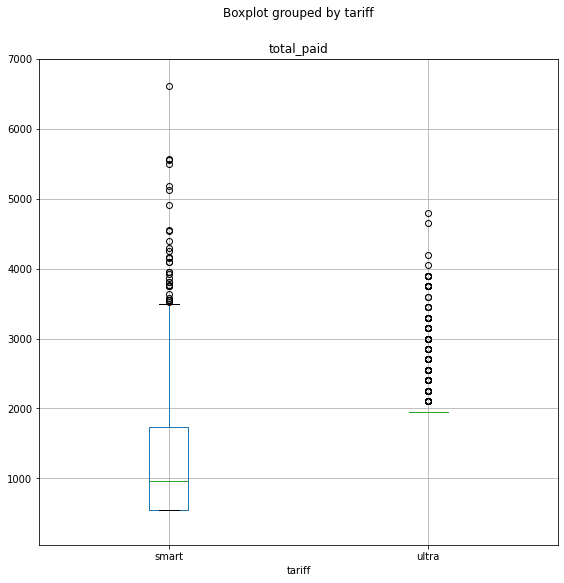

In [29]:
telecom_data.boxplot('total_paid', by='tariff', figsize=(9,9)).set_ylim(50,7000);

Таким образом, для тарифа Смарт характерно скошенное распределение тогда, когда у Ультра все оплаты концентрируются около 2000 руб. Построим дополнительно по каждому из тарифу гистрограмму и выведем медиальное, среднее, дисперсию и стандартного отклонение по каждому из тарифов.

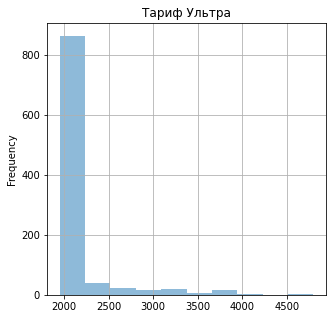

In [30]:
telecom_data[telecom_data['tariff'] == 'ultra']['total_paid'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
plt.title('Тариф Ультра');

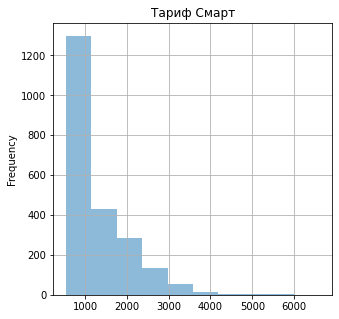

In [31]:
telecom_data[telecom_data['tariff'] == 'smart']['total_paid'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
plt.title('Тариф Смарт');

In [32]:
(telecom_data
            .pivot_table(index = 'tariff', values = 'total_paid', aggfunc = ['median','mean','var','std'])
            .style.format("{:.1f}")
)

,median,mean,var,std
,total_paid,total_paid,total_paid,total_paid
tariff,,,,
smart,961.7,1257.2,641149.1,800.7
ultra,1950.0,2070.2,141516.7,376.2


Анализ гистограмм и основных показателей выборки подтвердил, что пользователи тарифа Ультра в основном платят ежемесячную плату (1950 руб.). Тогда когда пользователи тарифа Смарт выходят за ежемесячную плату и используют дополнительные услуги. Также для Смарта характерно скошенное вправо распределение.

Проведем анализ по продолжительности звонков.

In [33]:
(telecom_data
             .pivot_table(index = 'tariff', values = 'month_calls_duration', aggfunc = ['median','mean','var','std'])
             .style.format("{:.1f}")
)

,median,mean,var,std
,month_calls_duration,month_calls_duration,month_calls_duration,month_calls_duration
tariff,,,,
smart,398.0,394.4,32386.4,180.0
ultra,488.1,497.1,89942.5,299.9


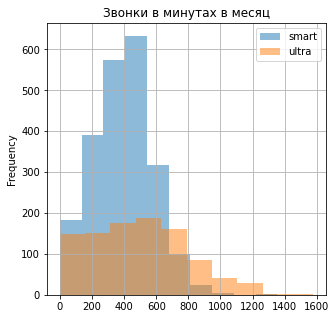

In [34]:
telecom_data[telecom_data['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
telecom_data[telecom_data['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
plt.title('Звонки в минутах в месяц')
plt.legend(['smart', 'ultra']);

На Смарте клиенты в месяц говорят около 400 минут, на Ультре - около 490 минут в месяц. Таким образом, на Смарте пользователи практически выговаривают весь лимит звонков (500 минут), остается запас в 100 минут, а на Ультре - остается значительный запас бесплатных минут (лимит - 3000 минут). Среднее и медиана практически совпадают на обоих тарифах.

Проведем анализ по используемым мб.

In [35]:
(telecom_data
            .pivot_table(index = 'tariff', values = 'mb_total_in_month', aggfunc = ['median','mean','var','std'])
            .style.format("{:.1f}")
)

,median,mean,var,std
,mb_total_in_month,mb_total_in_month,mb_total_in_month,mb_total_in_month
tariff,,,,
smart,16507.0,16208.9,34462562.8,5870.5
ultra,19309.0,19469.3,101751558.0,10087.2


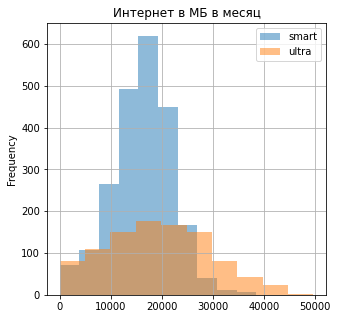

In [36]:
telecom_data[telecom_data['tariff'] == 'smart']['mb_total_in_month'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
telecom_data[telecom_data['tariff'] == 'ultra']['mb_total_in_month'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
plt.title('Интернет в МБ в месяц')
plt.legend(['smart', 'ultra']);

На Смарте клиенты в месяц используют около 16 гб, на Ультре - около 19 гб в месяц. Таким образом, на Смарте пользователи используют весь лимит (15 гб) и даже больше, а на Ультре - остается значительный запас бесплатных гб (лимит - 30 гб). Среднее и медиана практически совпадают на обоих тарифах.

Проведем анализ по количеству сообщений.

In [37]:
(telecom_data
             .pivot_table(index = 'tariff', values = 'sms_total_in_month', aggfunc = ['median','mean','var','std'])
             .style.format("{:.1f}")
)

,median,mean,var,std
,sms_total_in_month,sms_total_in_month,sms_total_in_month,sms_total_in_month
tariff,,,,
smart,28.0,33.4,796.8,28.2
ultra,38.0,49.4,2285.3,47.8


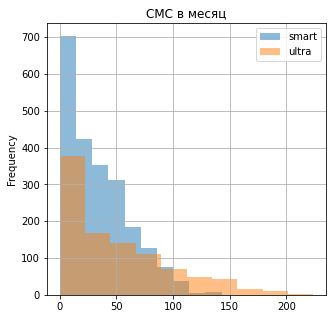

In [38]:
telecom_data[telecom_data['tariff'] == 'smart']['sms_total_in_month'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
telecom_data[telecom_data['tariff'] == 'ultra']['sms_total_in_month'].plot(kind='hist', bins=10, grid=True, figsize = (5,5), alpha=0.5)
plt.title('СМС в месяц')
plt.legend(['smart', 'ultra'])

Поведение пользователей выглядит похожим. На обоих тарифах практически не пользуются смс, среднее количество в месяц на обоих тарифах в пределах бесплатного лимита (Смарт - 50, Ультра -  1000). 

## Проверка гипотез <a id='hypothesis'></a>

Напишем функцию для удаления выбросов.

In [39]:
def delete_outliers(telecom_data, column, graphic=0, x = 10, y = 10):
    q1 = telecom_data[column].quantile(0.25)                 
    q3 = telecom_data[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (telecom_data[column] >= (q1 - 1.5 * iqr)) & (telecom_data[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return telecom_data.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return telecom_data.loc[iqr_test]

Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.

Проверим, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Для это сформулируем нулевую и альтернативную гипотезы:

**H0:** выручка пользователей тарифов «Ультра» и «Смарт» не различается.  
**H1:** выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [40]:
ultra = telecom_data[telecom_data['tariff'] == 'ultra']
smart = telecom_data[telecom_data['tariff'] == 'smart']
ultra = delete_outliers(ultra, 'total_paid', 0)
ultra = telecom_data['total_paid']
smart = delete_outliers(smart, 'total_paid', 0)
smart = smart['total_paid']
alpha = 0.05
results = st.ttest_ind(ultra, smart)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4436073750351825e-43

Отвергаем нулевую гипотезу


Таким образом, выручка пользователей тарифов «Ультра» и «Смарт» различается.

Проверим, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Для это сформулируем нулевую и альтернативную гипотезы:

**H0:** средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
**H1:** средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [41]:
telecom_data['region'] = np.where(telecom_data['city'] == 'Москва', 'Москва', 'Другие')
moscow = telecom_data[telecom_data['region'] == 'Москва']
other = telecom_data[telecom_data['region'] == 'Другие']
moscow = delete_outliers(moscow, 'total_paid', 0)
moscow = moscow['total_paid']
other = delete_outliers(other, 'total_paid', 0)
other = other['total_paid']
alpha = 0.05
results = st.ttest_ind(moscow, other)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.242673583054445

Не получилось отвергнуть нулевую гипотезу


Таким образом, с вероятностью в 24% такой результат может быть получен случайно. Средняя выручка пользователей из Москвы может не отличается от выручки пользователей из других регионов.

## Общий ввод <a id='conclusion'></a>
Таким образом, проанализировав данные 500 пользователей «Мегалайна» за 2018 год было выявлено:
1. Общая сумма платежей в месяц колеблется от 550 руб. до 6613 руб. 
2. Количество клиентов, использующие тариф Смарт, больше, чем клиентов, использующий тариф Ультра, приблизительно в два раза. Тариф Смарт приносит больше выручки, чем Ультра.
3. Пользователи тарифа Ультра в основном платят ежемесячную плату (1950 руб.) тогда, когда пользователи тарифа Смарт выходят за ежемесячную плату и используют дополнительные услуги (минуты и гб).
4. На Смарте пользователи практически выговаривают весь лимит звонков, а на Ультре - остается значительный запас бесплатных минут. 
5. На Смарте клиенты используют сверх лимита бесплатного интернета, а на Ультре - остается значительный запас бесплатных гб.
6. На обоих тарифах практически не пользуются смс.
7. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
8. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. 

Рекомендуется провести оптимизацию тарифов, на Смарте клиенты близки к лимитам, то на Ультре - остаются большие неизрасходованные запасы минут, гб и смс. При этом выручка от Смарта выше, чем от Ультры.
